In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#from wordcloud import WordCloud

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
df = pd.read_csv('tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [5]:
df.shape

(40000, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [7]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.drop('tweet_id', axis=1, inplace=True)

In [10]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

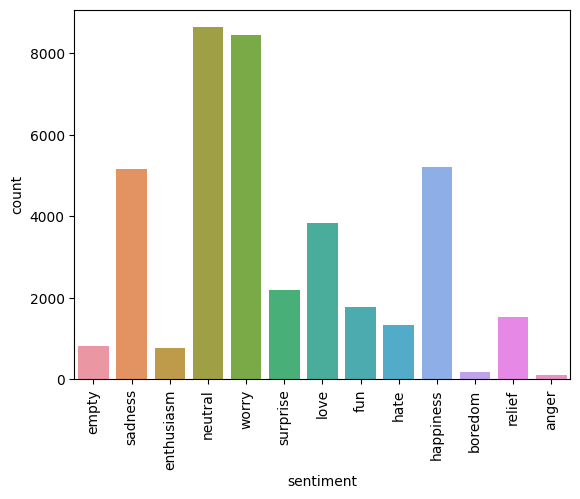

In [11]:
sns.countplot(x=df['sentiment'])
plt.xticks(rotation=90)
plt.show()

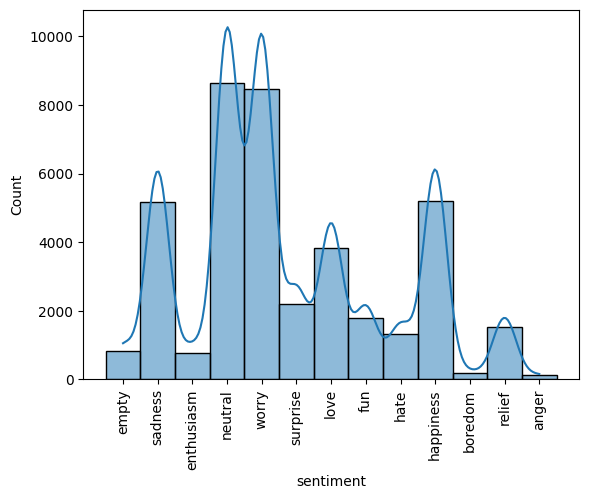

In [12]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/kjf4ec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kjf4ec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kjf4ec/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kjf4ec/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Remove junk

In [15]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    
    # return processed df
    return df

In [16]:
df = text_preprocessing_platform(df, 'content', remove_stopwords=True)

In [17]:
df.head()

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin n bed headache ughhhh waitin call
2,sadness,funeral ceremony gloomy friday
3,enthusiasm,want hang friends soon
4,neutral,dannycastillo want trade someone houston ticke...


In [18]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [19]:
def categorize_sentiment(row):
    if row['sentiment'] in ['empty', 'sadness', 'anger', 'worry', 'hate', 'boredom']:
        return 'Concerned'
    #elif row['sentiment'] in ['neutral']:  # Note: 'empty' appears again; check if this is correct.
    #    return 'Neutral'
    elif row['sentiment'] in ['enthusiasm', 'happiness', 'love', 'fun', 'surprise', 'relief']:
        return 'Not Concerned'
    elif row['sentiment'] in ['neutral']:
        return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories
#df = df[df['sentiment'] != 'neutral']
# Apply the function along the rows of the DataFrame
df['category'] = df.apply(categorize_sentiment, axis=1)

# Balance data

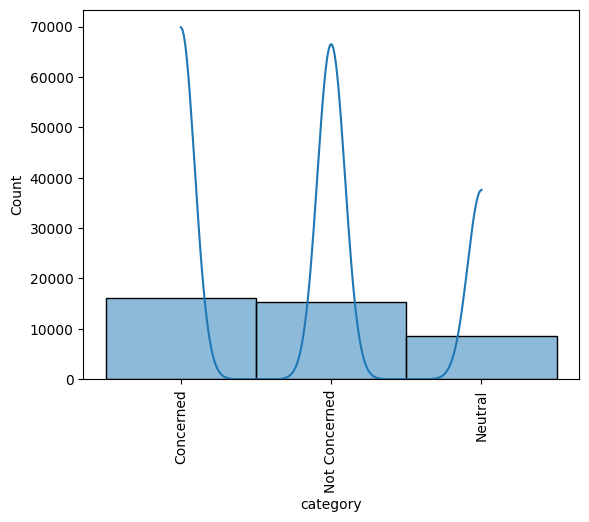

In [20]:
sns.histplot(x=df['category'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [21]:
df['category'].value_counts()

Concerned        16063
Not Concerned    15299
Neutral           8638
Name: category, dtype: int64

In [22]:
df

,sentiment,content,category
0,empty,tiffanylue know listenin bad habit earlier sta...,Concerned
1,sadness,layin n bed headache ughhhh waitin call,Concerned
2,sadness,funeral ceremony gloomy friday,Concerned
3,enthusiasm,want hang friends soon,Not Concerned
4,neutral,dannycastillo want trade someone houston ticke...,Neutral
...,...,...,...
39995,neutral,johnlloydtaylor,Neutral
39996,love,happy mother day love,Not Concerned
39997,love,happy mother day mommies woman man long momma ...,Not Concerned
39998,happiness,niariley wassup beautiful follow peep new hit ...,Not Concerned


In [23]:
label_mapping = {'Not Concerned': 0, 'Neutral':1, 'Concerned': 2}
df['category'] = df['category'].map(label_mapping)

In [24]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 28000; Test: 12000


In [25]:
train_df

,sentiment,content,category
38015,sadness,ficklampa hehe option advertise world mess mig...,2
2281,boredom,wake day need go work suck also go dentist fil...,2
36629,neutral,ilhongy would get,1
6087,worry,penbleth leave forever miss much,2
11792,neutral,lt train today ehhh hard tall hard feel good s...,1
...,...,...,...
6265,neutral,clean,1
11284,hate,ooo goddddd vodafone trouble network,2
38158,fun,watch run fat boy run haha soo funny,0
860,hate,calvinharris make pork products fuck stop impo...,2


In [26]:
X_train = train_df['content'].values
y_train = train_df['category'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['category'].values

X_test = test_df['content'].values
y_test = test_df['category'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 28000; X_test: 9000; X_valid: 3000
y_train: 28000; y_test: 9000; y_valid: 3000


In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [28]:
from transformers import RobertaTokenizerFast

In [29]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

In [30]:
is_train=True

In [31]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


In [32]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

# Batch size: 128 Learning Rate: 1e-4

In [33]:

# Define the RoBERTa model and tokenizer
model_name = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128)
valid_dataset = TensorDataset(X_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=128)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, valid_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)
    
test_cm, test_report = evaluate(model, test_dataloader)
    
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)

valid_cm, valid_report = evaluate(model, valid_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

Epoch 1/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.0751


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.73it/s]


Validation Loss: 1.0798
Epoch 2/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.0720


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 1.0711
Epoch 3/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.0737


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 1.0696
Epoch 4/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.94it/s]


Training Loss: 1.0723


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.0756
Epoch 5/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.94it/s]


Training Loss: 1.0712


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 1.0810
Epoch 6/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.94it/s]


Training Loss: 1.0722


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.0698
Epoch 7/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.94it/s]


Training Loss: 1.0707


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.0714
Epoch 8/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.94it/s]


Training Loss: 1.0715


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.68it/s]


Validation Loss: 1.0736
Epoch 9/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.94it/s]


Training Loss: 1.0709


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.0703
Epoch 10/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.94it/s]


Training Loss: 1.0705


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.0733
Test Set Evaluation:
Confusion Matrix:
[[   0    0 3442]
 [   0    0 1950]
 [   0    0 3608]]
Classification Report:
               precision    recall  f1-score   support

Not Concerned       0.00      0.00      0.00      3442
      Neutral       0.00      0.00      0.00      1950
    Concerned       0.40      1.00      0.57      3608

     accuracy                           0.40      9000
    macro avg       0.13      0.33      0.19      9000
 weighted avg       0.16      0.40      0.23      9000

Validation Set Evaluation:
Confusion Matrix:
[[   0    0 1162]
 [   0    0  670]
 [   0    0 1168]]
Classification Report:
               precision    recall  f1-score   support

Not Concerned       0.00      0.00      0.00      1162
      Neutral       0.00      0.00      0.00       670
    Concerned       0.39      1.00      0.56      1168

     accuracy                           0.39      3000
    macro avg       0.13      0.33      0.19      3000
 weighted avg   

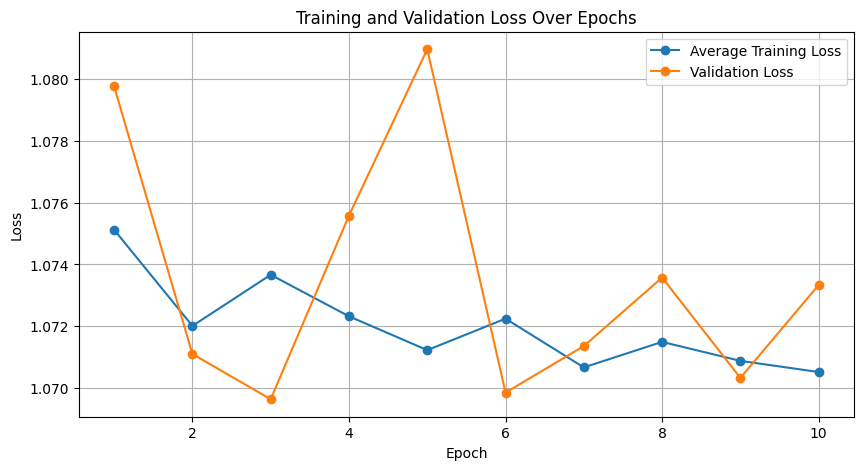

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_over_epochs(training_loss, val_losses):

    if len(training_loss) != len(val_losses):
        raise ValueError("train_losses and val_losses must be of the same length.")
    
    epochs = list(range(1, len(training_loss) + 1))
    
    # Create DataFrame to organize the data
    model_loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Average Training Loss': training_loss,
        'Validation Loss': val_losses
    })
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(model_loss_df['Epoch'], model_loss_df['Average Training Loss'], label='Average Training Loss', marker='o')
    plt.plot(model_loss_df['Epoch'], model_loss_df['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_over_epochs(training_loss, validation_loss)

# Batch size: 128 Learning Rate: 1e-6

In [36]:

# Define the RoBERTa model and tokenizer
model_name = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128)
valid_dataset = TensorDataset(X_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=128)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, valid_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)
    
test_cm, test_report = evaluate(model, test_dataloader)
    
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)

valid_cm, valid_report = evaluate(model, valid_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

Epoch 1/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.0774


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 1.0809
Epoch 2/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.0495


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.71it/s]


Validation Loss: 1.0753
Epoch 3/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 0.9655


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 1.0269
Epoch 4/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 0.9142


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 0.9941
Epoch 5/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 0.8940


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 0.9900
Epoch 6/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 0.8822


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 0.9707
Epoch 7/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 0.8714


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 0.9530
Epoch 8/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 0.8631


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 0.9295
Epoch 9/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 0.8615


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 0.9432
Epoch 10/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 0.8533


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 0.9532
Test Set Evaluation:
Confusion Matrix:
[[1736  269 1437]
 [ 378  390 1182]
 [ 442  228 2938]]
Classification Report:
               precision    recall  f1-score   support

Not Concerned       0.68      0.50      0.58      3442
      Neutral       0.44      0.20      0.27      1950
    Concerned       0.53      0.81      0.64      3608

     accuracy                           0.56      9000
    macro avg       0.55      0.51      0.50      9000
 weighted avg       0.57      0.56      0.54      9000

Validation Set Evaluation:
Confusion Matrix:
[[602  99 461]
 [142 135 393]
 [121  93 954]]
Classification Report:
               precision    recall  f1-score   support

Not Concerned       0.70      0.52      0.59      1162
      Neutral       0.41      0.20      0.27       670
    Concerned       0.53      0.82      0.64      1168

     accuracy                           0.56      3000
    macro avg       0.55      0.51      0.50      3000
 weighted avg       0.57 

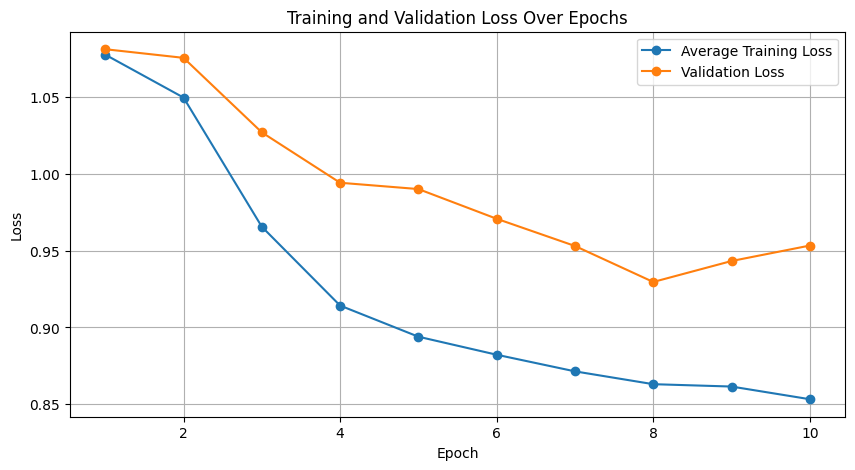

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_over_epochs(training_loss, val_losses):

    if len(training_loss) != len(val_losses):
        raise ValueError("train_losses and val_losses must be of the same length.")
    
    epochs = list(range(1, len(training_loss) + 1))
    
    # Create DataFrame to organize the data
    model_loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Average Training Loss': training_loss,
        'Validation Loss': val_losses
    })
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(model_loss_df['Epoch'], model_loss_df['Average Training Loss'], label='Average Training Loss', marker='o')
    plt.plot(model_loss_df['Epoch'], model_loss_df['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_over_epochs(training_loss, validation_loss)

# Batch size: 128 Learning Rate: 1e-8

In [39]:

# Define the RoBERTa model and tokenizer
model_name = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128)
valid_dataset = TensorDataset(X_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=128)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, valid_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)
    
test_cm, test_report = evaluate(model, test_dataloader)
    
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)

valid_cm, valid_report = evaluate(model, valid_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

Epoch 1/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1521


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 1.1315
Epoch 2/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1481


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 1.1297
Epoch 3/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1417


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.1279
Epoch 4/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1401


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.1258
Epoch 5/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1315


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 1.1230
Epoch 6/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1274


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.1213
Epoch 7/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1238


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.1196
Epoch 8/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1221


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.1182
Epoch 9/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1152


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.1154
Epoch 10/10


Training: 100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Training Loss: 1.1139


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Validation Loss: 1.1132
Test Set Evaluation:
Confusion Matrix:
[[3442    0    0]
 [1950    0    0]
 [3608    0    0]]
Classification Report:
               precision    recall  f1-score   support

Not Concerned       0.38      1.00      0.55      3442
      Neutral       0.00      0.00      0.00      1950
    Concerned       0.00      0.00      0.00      3608

     accuracy                           0.38      9000
    macro avg       0.13      0.33      0.18      9000
 weighted avg       0.15      0.38      0.21      9000

Validation Set Evaluation:
Confusion Matrix:
[[1162    0    0]
 [ 670    0    0]
 [1168    0    0]]
Classification Report:
               precision    recall  f1-score   support

Not Concerned       0.39      1.00      0.56      1162
      Neutral       0.00      0.00      0.00       670
    Concerned       0.00      0.00      0.00      1168

     accuracy                           0.39      3000
    macro avg       0.13      0.33      0.19      3000
 weighted avg   

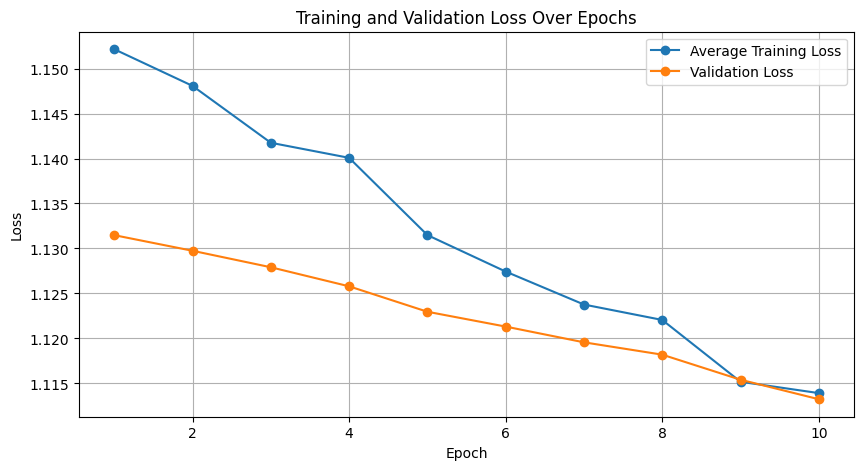

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_over_epochs(training_loss, val_losses):

    if len(training_loss) != len(val_losses):
        raise ValueError("train_losses and val_losses must be of the same length.")
    
    epochs = list(range(1, len(training_loss) + 1))
    
    # Create DataFrame to organize the data
    model_loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Average Training Loss': training_loss,
        'Validation Loss': val_losses
    })
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(model_loss_df['Epoch'], model_loss_df['Average Training Loss'], label='Average Training Loss', marker='o')
    plt.plot(model_loss_df['Epoch'], model_loss_df['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_over_epochs(training_loss, validation_loss)